# Clear Creek Forecast

Use the GeoJSON Clear Creek dataset to generate a forecast.

In [1]:
from NEXT import NEXT
from NEXT.data import all_data_gpkg
import NEXT.data as ndata
import NEXT.wforecast as wfc
import matplotlib.pyplot as plt
import geopandas as gp
import pandas as pd
import warnings
import py3dep as p3d
import os
bp = "/scratch/dphilippus/notebooks/ccfc/"
base_df = bp + "base_inp.csv"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


In [2]:
gpkg_path = "clear_ck.geojson"

In [3]:
geo = gp.read_file(gpkg_path)

In [4]:
geo

,divide_id,toid,type,ds_id,areasqkm,id,lengthkm,tot_drainage_areasqkm,has_flowline,geometry
0,cat-1561662,nex-1561660,network,None,10.272150,wb-1561662,3.912857,17.395650,True,"POLYGON ((-105.38 39.689, -105.39 39.688, -105..."
1,cat-1561693,nex-1561694,network,None,23.875199,wb-1561693,6.565050,29.484450,True,"POLYGON ((-105.74 39.597, -105.74 39.597, -105..."
2,cat-1561753,nex-1561636,network,None,13.279499,wb-1561753,6.903318,27.470700,True,"POLYGON ((-105.34 39.788, -105.34 39.79, -105...."
3,cat-1561618,nex-1561619,network,None,5.856751,wb-1561618,2.987772,40.154401,True,"POLYGON ((-105.85 39.686, -105.86 39.685, -105..."
4,cat-1561619,nex-1561620,network,None,8.104951,wb-1561619,3.502942,62.124751,True,"POLYGON ((-105.81 39.705, -105.81 39.702, -105..."
...,...,...,...,...,...,...,...,...,...,...
114,cat-1561668,nex-1561631,network,None,16.689150,wb-1561668,7.782792,36.214198,True,"POLYGON ((-105.52 39.723, -105.52 39.722, -105..."
115,cat-1561692,nex-1561693,network,None,5.609250,wb-1561692,2.116735,5.609250,True,"POLYGON ((-105.75 39.596, -105.75 39.596, -105..."
116,cat-1561695,nex-1561696,network,None,7.276050,wb-1561695,4.120794,41.594850,True,"POLYGON ((-105.71 39.678, -105.71 39.679, -105..."
117,cat-1561744,nex-1561737,network,None,11.991150,wb-1561744,6.066944,11.991150,True,"POLYGON ((-105.43 39.806, -105.43 39.806, -105..."


In [5]:
rivers = gp.read_file("data/ccnhd/NHDFlowline.shp")
rivers = rivers.loc[(rivers["gnis_name"].notna()) & (rivers["ftype"].isin([460, 558]))]

/u/wy/ch/dphilippus/.conda/envs/next/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


<Axes: >

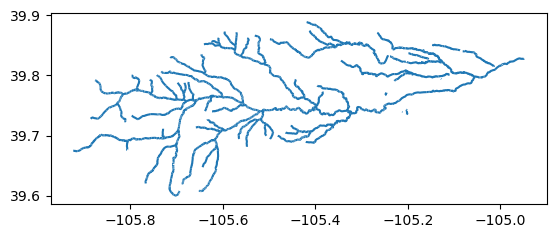

In [6]:
rivers.plot()

# Baseline Data

In [18]:
data_gen = all_data_gpkg(gpkg_path, "2022-01-01", "2023-12-31", handler=lambda k, g, e: print(e))

In [ ]:
for (nm, df) in data_gen:
    if df is not None:
        df["site_id"] = nm
        df.to_csv(base_df, index=False, mode="a", header=not os.path.exists(base_df))
        print("|", end="")

# Forecast

In [10]:
date = "2025-04-16"

In [8]:
fit_data = pd.read_csv(base_df, parse_dates=["date"]).drop(columns="id").assign(id=lambda x: x["site_id"])
model = NEXT.from_pickle("coefs.pickle")

In [9]:
gpg = ndata.gpkg_geoms(gpkg_path)

In [21]:
def trycatch(x):
    try:
        print("|", end="")
        return x()
    except Exception as e:
        print(e, end="")
        return None
# weather = ndata.weather_hrrr
weather = lambda geo, start, end: pd.DataFrame({"tmax": wfc.get_gfs_downloaded(geo, "".join(start.split("-")), "cache/")}).reset_index()
forecast_data = pd.concat([
    trycatch(lambda: weather(x[0], "2025-04-03", date).assign(id=nm))
    for (nm, x) in gpg.items()
])

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [22]:
def predict(gid, data):
    # For grouped data.
    fcd = forecast_data.loc[forecast_data["id"] == gid]
    if len(fcd) > 0:
        return model.make_newt(data, reset=True).run(fcd)
    return None

In [23]:
prd = pd.concat([predict(gid, data) for (gid, data) in fit_data.groupby("id")])
# prd = prd.loc[prd["date"] == prd["date"].max()]  # last day only
prd = prd.loc[prd["date"] == date]

# Map It

In [26]:
nexus = gp.read_file("clear_ck_nexus.geojson")

In [ ]:
mdat = nexus.merge(prd[["id", "temp.mod"]].merge(geo[["id", "toid"]], on="id"), left_on="id", right_on="toid", how="left")
mdat = mdat.loc[-mdat["temp.mod"].isna()]

## General Audience Version

Fahrenheit, no lat/lon, bigger DEM area, etc.

In [29]:
bbox = (-106.2, 39.47, -104.8, 40)
dem = p3d.get_dem(bbox, 100)

In [ ]:
mdat["temp.F"] = mdat["temp.mod"] * 1.8 + 32 # C to F
fig, ax = plt.subplots(1, 1, figsize=(13, 7), layout="compressed")
dem.plot.contour(ax=ax, add_colorbar=False, add_labels=False, cmap="grey", levels=15)
rivers.plot(ax=ax, linewidth=4)
datestr = str(prd['date'].iloc[0]).split()[0]
mplt = mdat.plot("temp.F", ax=ax, legend=True, markersize=100, zorder=99,
                 cmap="plasma",
                 legend_kwds={"label": f"Daily Mean River Temperature Forecast for {datestr} [deg F]",
                             "pad": 0, "location": "top"})
ax.annotate("Colorado\nSchool of\nMines", (-105.223799, 39.7517965),
            xytext=(-105.1, 39.65), arrowprops={"color": "grey"}, backgroundcolor="lightblue", size="large")
ax.annotate("Mount Blue Sky", (-105.6464969, 39.5884301),
            xytext=(-105.55, 39.5), arrowprops={"color": "grey"}, backgroundcolor="lightblue", size="large")
ax.annotate("Loveland Pass", (-105.8797386, 39.6635642),
            xytext=(-105.93, 39.6), arrowprops={"color": "grey"}, backgroundcolor="lightblue", size="large")
ax.annotate("North", (-105, 39.6), xytext=(-105.025, 39.5), arrowprops={"arrowstyle": "fancy",
                                                                      "color": "black"},
           c="white", backgroundcolor="black", size="large")
ax.annotate("The Rocky Mountains near Golden", (-105.7, 39.97), backgroundcolor="lightblue", size="x-large")
ax.annotate("Clear Creek", (-105, 39.82), backgroundcolor="lightblue", size="large")
ax.annotate("Good spawning\ntemperature", (-105.355, 39.715), xytext=(-105.4, 39.6),
            arrowprops={"color": "orange"}, size="large", bbox={"boxstyle": "ellipse", "color": "orange"})
ax.annotate("Too cold", (-105.848, 39.75), xytext=(-106, 39.76), backgroundcolor="purple", arrowprops={"color": "purple"}, size="large",
           c="white", bbox={"boxstyle": "sawtooth", "color": "purple"})
ax.set_axis_off()
# cb.set_label(label=f"Daily Mean River Temperature Forecast for {datestr} [deg F]", size=2)
# ax.set_xlabel("Elevation map from USGS 3DEP | Trout image from Colorado Parks and Wildlife")  # unrelated, but for slide
# ax.set_title(f"Daily Mean River Temperature Forecast for {datestr}")
plt.savefig("ccfc.png", dpi=300)

## Technical Version

In [33]:
bbox = (-106, 39.55, -104.8, 39.95)
dem = p3d.get_dem(bbox, 100)

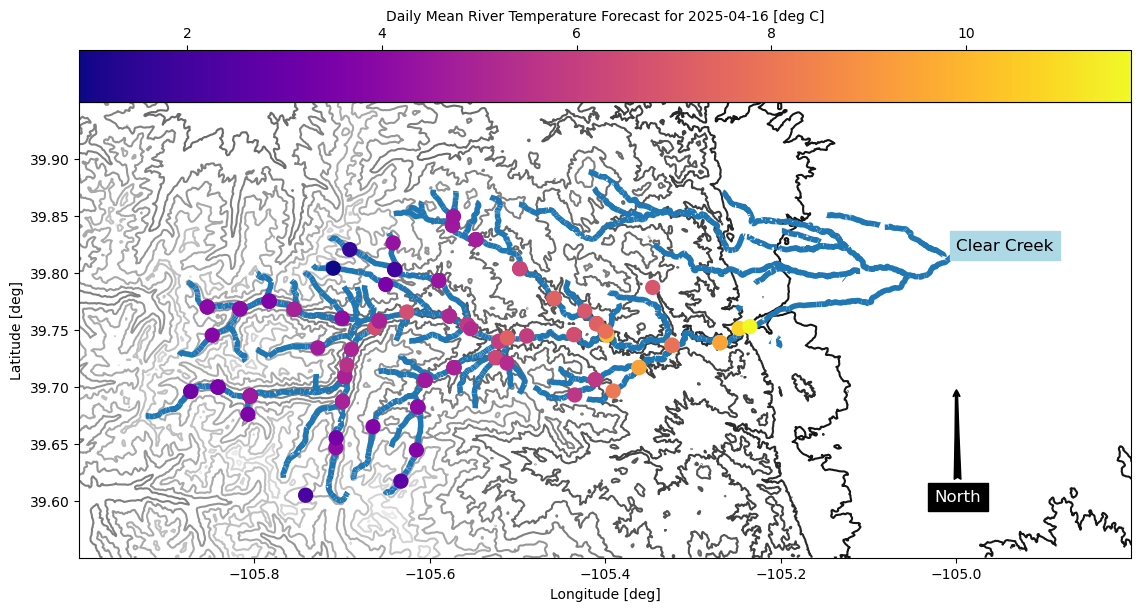

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6), layout="compressed")
dem.plot.contour(ax=ax, add_colorbar=False, add_labels=False, cmap="grey", levels=15)
rivers.plot(ax=ax, linewidth=4)
datestr = str(prd['date'].iloc[0]).split()[0]
mplt = mdat.plot("temp.mod", ax=ax, legend=True, markersize=100, zorder=99,
                 cmap="plasma",
                 legend_kwds={"label": f"Daily Mean River Temperature Forecast for {datestr} [deg C]",
                             "pad": 0, "location": "top"})
ax.annotate("North", (-105, 39.7), xytext=(-105.025, 39.6), arrowprops={"arrowstyle": "fancy",
                                                                      "color": "black"},
           c="white", backgroundcolor="black", size="large")
ax.annotate("Clear Creek", (-105, 39.82), backgroundcolor="lightblue", size="large")
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
plt.savefig("ccfc_technical.png", dpi=300)